# 0. Data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

Let's import data with created features via scripts.

In [2]:
df1 = pd.read_csv('client_summary_segmentation.csv')
df2 = pd.read_csv('client_transaction_product_file.csv')

df = pd.merge(df1, df2, on="client_id", how="inner")

In [3]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df = df.rename(columns={'type': 'client_type'})

In [4]:
df.head()

,client_id,interaction_rate,avg_keyword_word_count,device_usage_category,average_time_between_searches_days,unique_prd_category_count,purchase_activity_rate,avg_products_seen,client_type,market,...,preferred_channel,nb_different_channels,avg_quantity_per_order,brand_name,favorite_prd_category_1,favorite_prd_category_2,favorite_prd_category_3,favorite_prd_category_4,most_ordered_product_2,most_ordered_product_3
0,000195,0.000000,2.338983,desktop_only,0.329478,15,0.016949,14.666667,Installateurs,Habitat / Petit Tertiaire,...,FACE,3,18,Fils et Câbles Rexel,CABLES,CABLE ET FIL DOMESTIQUE,FIL RIGIDE H07VU,Fil rigide H07VU,11d34252,2d8c77f3
1,0002b0,0.014286,3.928571,desktop_only,0.000256,13,0.000000,7.111111,Installateurs,Habitat / Petit Tertiaire,...,FACE,1,2,Iboco,APPAREILLAGE ET CONTROLE DU BATIMENT,BOITE D'ENCASTREMENT ET DE DERIVATION,BOITE ETANCHE,Boîte étanche,644e50d8,6de087d2
2,000973,0.007692,2.615385,desktop_only,0.040482,42,0.000000,8.133333,Utilisateurs,Tertiaire,...,TEL,1,35,Schneider Electric,"OUTILLAGE, MESURE ET FIXATION",CABLE INDUSTRIEL,CABLE SOUPLE H07RNF ET RV-K,FIXATION TUBE ET CABLE PLASTIQUE,06f44771,0b2f35fd
3,0013cd,0.023810,2.964286,desktop_only,0.217796,21,0.000000,7.625000,Utilisateurs,Tertiaire,...,DIGIT,1,35,Fils et Câbles Rexel,CABLES,CABLE INDUSTRIEL,CABLE R2V SENSIBLE 1.5² ET 2.5²,CABLE R2V SENSIBLE 1.5² ET 2.5²,b17d132e,de22d488
4,0017ab,0.000000,4.000000,desktop_only,1.145314,1,0.000000,6.000000,Installateurs,Tertiaire,...,FACE,2,18,Bizline,"OUTILLAGE, MESURE ET FIXATION",MARQUAGE ET REPERAGE,COLLIER DE CABLAGE,COLLIER DE CABLAGE,67c69581,8edf9167


# 1. EDA

In [5]:
def analyse_data(df):

    num_unique_values = df.nunique()
    non_null_percentage = df.notnull().mean() * 100
    non_null_count = df.count()
    column_types = df.dtypes

    analysis_df = pd.DataFrame({
        'count_non_null_values': non_null_count,    
        '%_non_null_values': non_null_percentage,
        'nb_unique_values': num_unique_values,
        'cardinal': num_unique_values/len(df),
        'column_type': column_types,
        })
    return analysis_df

In [6]:
analyse_data(df)

,count_non_null_values,%_non_null_values,nb_unique_values,cardinal,column_type
client_id,23662,100.000000,23662,1.000000,object
interaction_rate,23662,100.000000,3242,0.137013,float64
avg_keyword_word_count,23662,100.000000,12177,0.514623,float64
device_usage_category,23662,100.000000,3,0.000127,object
average_time_between_searches_days,23662,100.000000,23524,0.994168,float64
unique_prd_category_count,23662,100.000000,347,0.014665,int64
purchase_activity_rate,23662,100.000000,3236,0.136759,float64
avg_products_seen,23662,100.000000,4275,0.180669,float64
client_type,23635,99.885893,6,0.000254,object
market,23635,99.885893,5,0.000211,object


We'll start by immediately dropping columns that are redundant or have too high cardinality.

In [7]:
columns_to_drop = ['most_buyed_product', 'most_ordered_product_1', 'most_ordered_product_2', 'most_ordered_product_3', 'favorite_prd_category_1', 'favorite_prd_category_3', 'favorite_prd_category_4', 'agence_code', 'brand_name']
df = df.drop(columns_to_drop, axis=1)

## 1.1 Missing values

Check for missing values

In [8]:
df.isnull().sum()

client_id                              0
interaction_rate                       0
avg_keyword_word_count                 0
device_usage_category                  0
average_time_between_searches_days     0
unique_prd_category_count              0
purchase_activity_rate                 0
avg_products_seen                      0
client_type                           27
market                                27
nb_total_orders                        0
nb_different_product_ordered           0
preferred_channel                      0
nb_different_channels                  0
avg_quantity_per_order                 0
favorite_prd_category_2                0
dtype: int64

Let's analyse the `client_type` and `market` columns

<Axes: xlabel='count', ylabel='market'>

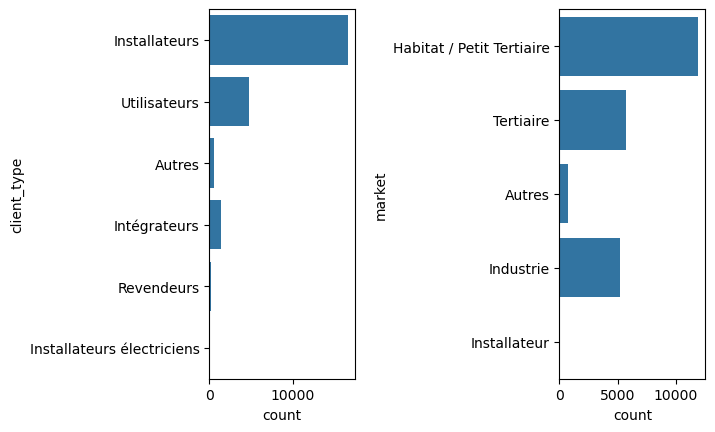

In [9]:
plt.subplot(131)
sns.countplot(df.client_type)

plt.subplot(133)
sns.countplot(df.market)

Since there are **dominant categories** in both columns, we'll use the **mode-based filling** method.

In [10]:
for col in ['client_type', 'market']:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)

## 1.2 Numerical columns

In [11]:
df.describe()

,interaction_rate,avg_keyword_word_count,average_time_between_searches_days,unique_prd_category_count,purchase_activity_rate,avg_products_seen,nb_total_orders,nb_different_product_ordered,nb_different_channels,avg_quantity_per_order
count,23662.000000,23662.000000,23662.000000,23662.000000,23662.000000,23662.000000,23662.000000,23662.000000,23662.000000,23662.000000
mean,0.007962,2.345944,0.294368,34.779224,0.024521,10.024561,8.937283,13.948018,1.727327,38.080086
std,0.017481,0.885313,0.607247,47.778509,0.071505,4.211266,16.269588,23.179981,0.763775,162.754525
min,0.000000,1.000000,0.000000,1.000000,0.000000,6.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,1.902439,0.054927,7.000000,0.000000,8.000000,2.000000,3.000000,1.000000,3.000000
50%,0.000000,2.213361,0.142510,17.000000,0.003413,9.000000,4.000000,6.000000,2.000000,10.000000
75%,0.010204,2.700855,0.322368,42.000000,0.021739,10.600000,9.000000,15.000000,2.000000,32.000000
max,0.857143,17.000000,28.199313,571.000000,3.142857,109.000000,547.000000,371.000000,4.000000,10100.000000


In [12]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df_num = df[num_cols]

Let's look at the districbution of the numerical columns

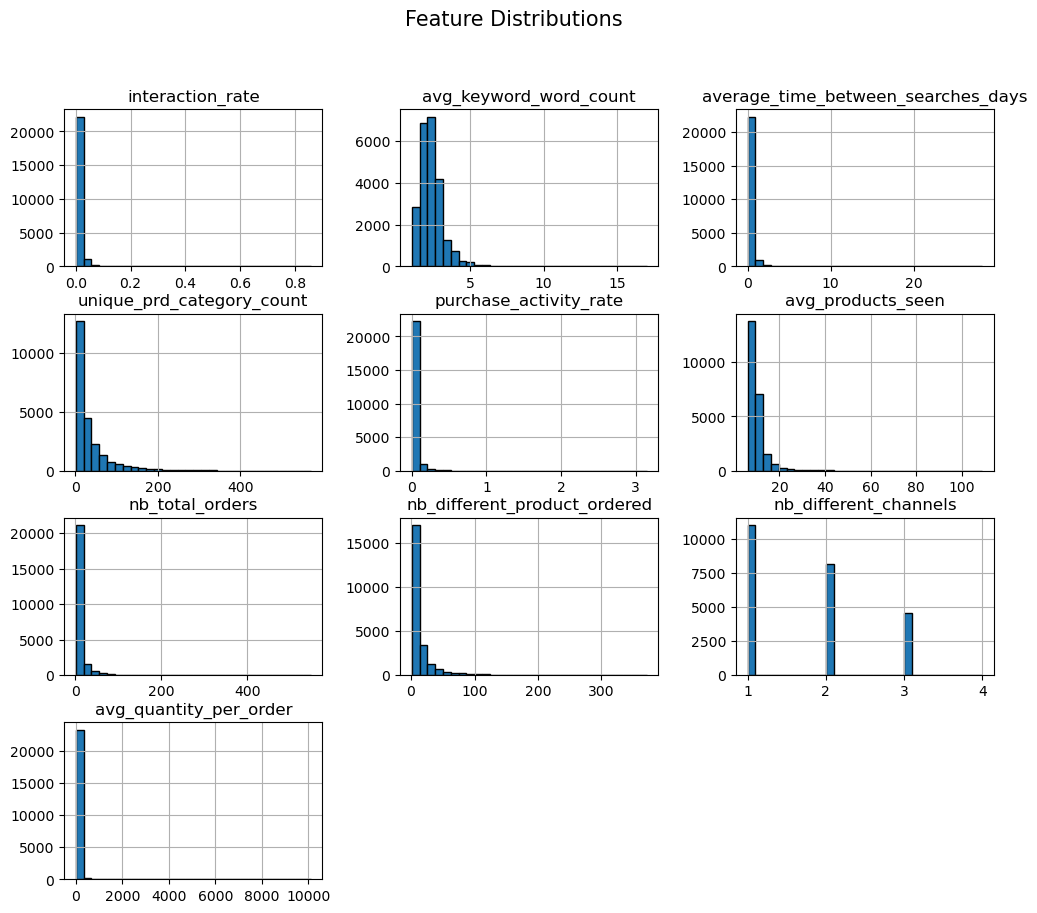

In [13]:
df_num.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=15)
plt.show()

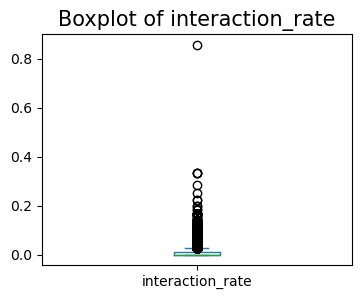

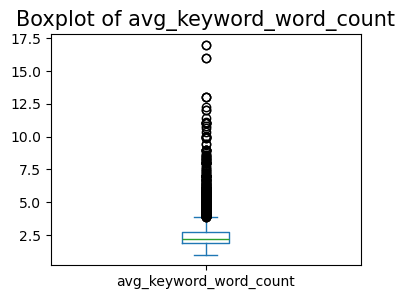

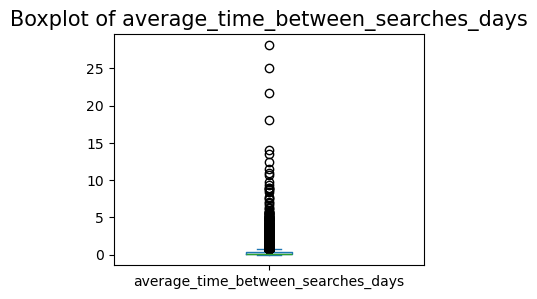

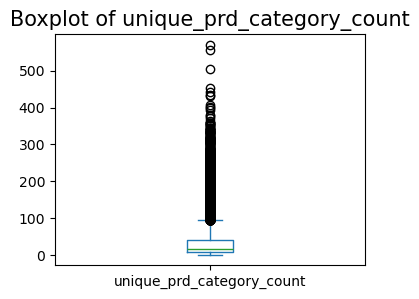

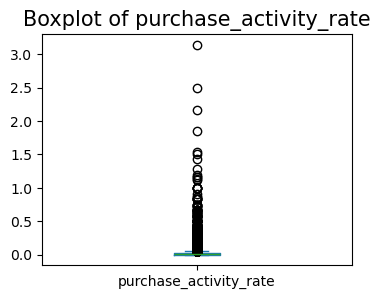

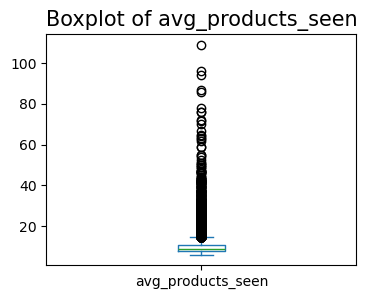

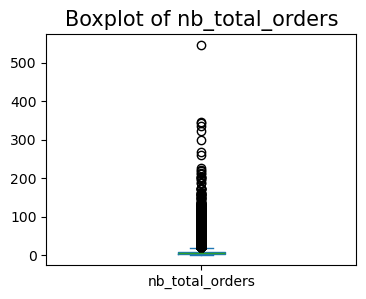

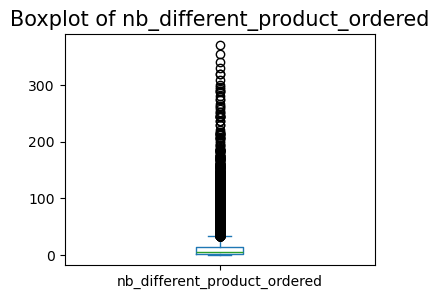

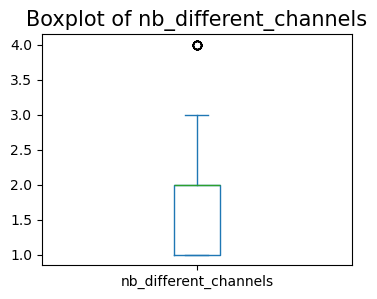

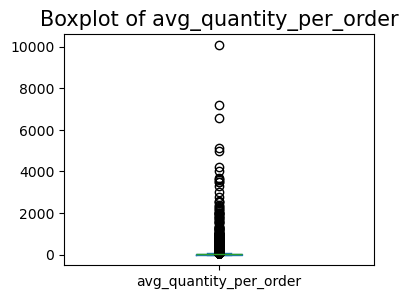

In [14]:
for column in df_num.columns:
    plt.figure(figsize=(4, 3))
    df_num[column].plot(kind='box')
    plt.title(f"Boxplot of {column}", fontsize=15)
    plt.show()


The **distributions are quite skewed** are there are **many outliers**. We'll see how we deal with this in the feature engineering part.

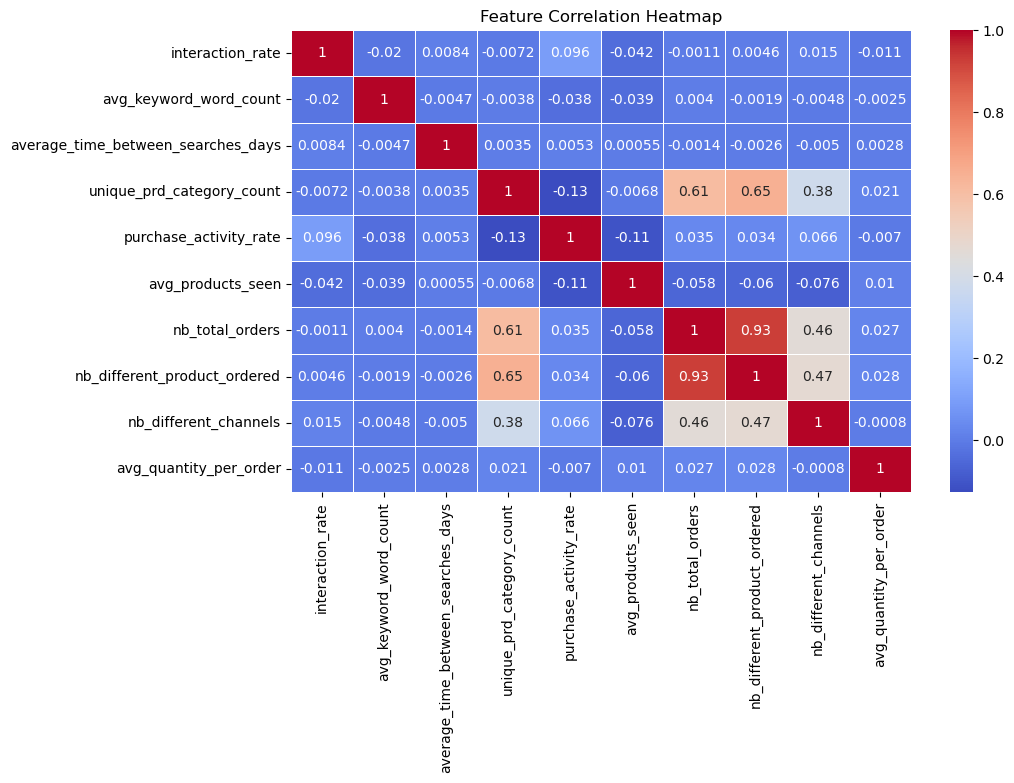

In [15]:
corr_matrix = df_num.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


Corrolation is very high between `nb_total_orders` and `nb_different_product_ordered` columns. We'll deal with this by droping one of them.

Variance check:

In [16]:
for col in num_cols:
    print(f"{col.ljust(40)} variance: {df[col].var():.6f}")


interaction_rate                         variance: 0.000306
avg_keyword_word_count                   variance: 0.783780
average_time_between_searches_days       variance: 0.368749
unique_prd_category_count                variance: 2282.785963
purchase_activity_rate                   variance: 0.005113
avg_products_seen                        variance: 17.734763
nb_total_orders                          variance: 264.699502
nb_different_product_ordered             variance: 537.311528
nb_different_channels                    variance: 0.583353
avg_quantity_per_order                   variance: 26489.035511


`interaction_rate` and `purchase_activity_rate` features have very low variance (<0.01)

# 1.3 Categorical columns

In [50]:
cat_columns = df.drop('client_id', axis=1).select_dtypes(include=['object', 'category']).columns

In [18]:
analyse_data(df[cat_columns])

,count_non_null_values,%_non_null_values,nb_unique_values,cardinal,column_type
client_id,23662,100.0,23662,1.000000,object
device_usage_category,23662,100.0,3,0.000127,object
client_type,23662,100.0,6,0.000254,object
market,23662,100.0,5,0.000211,object
preferred_channel,23662,100.0,4,0.000169,object
favorite_prd_category_2,23662,100.0,117,0.004945,object


# 2. Feature engineering

## 2.1. Feature selection, correction and creation

Let's start by **droping** `nb_different_product_ordered` column as it is **very corrolated** with `nb_total_orders` (cor=0.93). Let's also **drop** `purchase_activity_rate` and `interaction_rate` as their **variance is too low**.

In [20]:
df_cleaned = df.drop(['nb_different_product_ordered', 'purchase_activity_rate', 'interaction_rate'], axis=1)

Then we can **fix the skew** for some of the numerical columns as skewness and extreme outliers can negetavely affect clustering performance. To do this, we will apply **logarithmic transformations**.

In [21]:
skewed_cols = ['average_time_between_searches_days', 'avg_products_seen', 'nb_total_orders', 'avg_quantity_per_order', 'unique_prd_category_count']

In [22]:
for col in skewed_cols:
    df_cleaned[col] = np.log1p(df_cleaned[col])

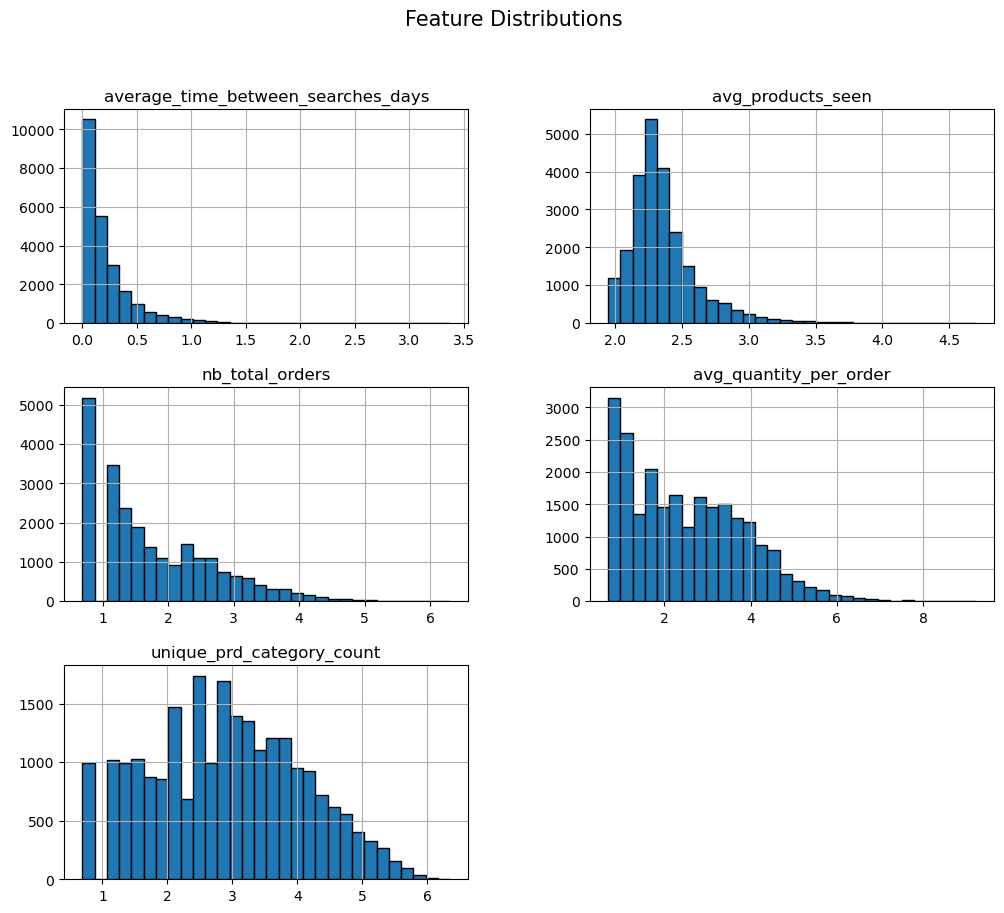

In [23]:
df_cleaned[skewed_cols].hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=15)
plt.show()

Skewness has largely improved, but many outliers remain. Let's apply **Winsorization** to cap values above the **95th percentile**.

In [24]:
for column in skewed_cols:
    upper_percentile = df_cleaned[column].quantile(0.95)
    df_cleaned[column] = df_cleaned[column].clip(upper=upper_percentile)

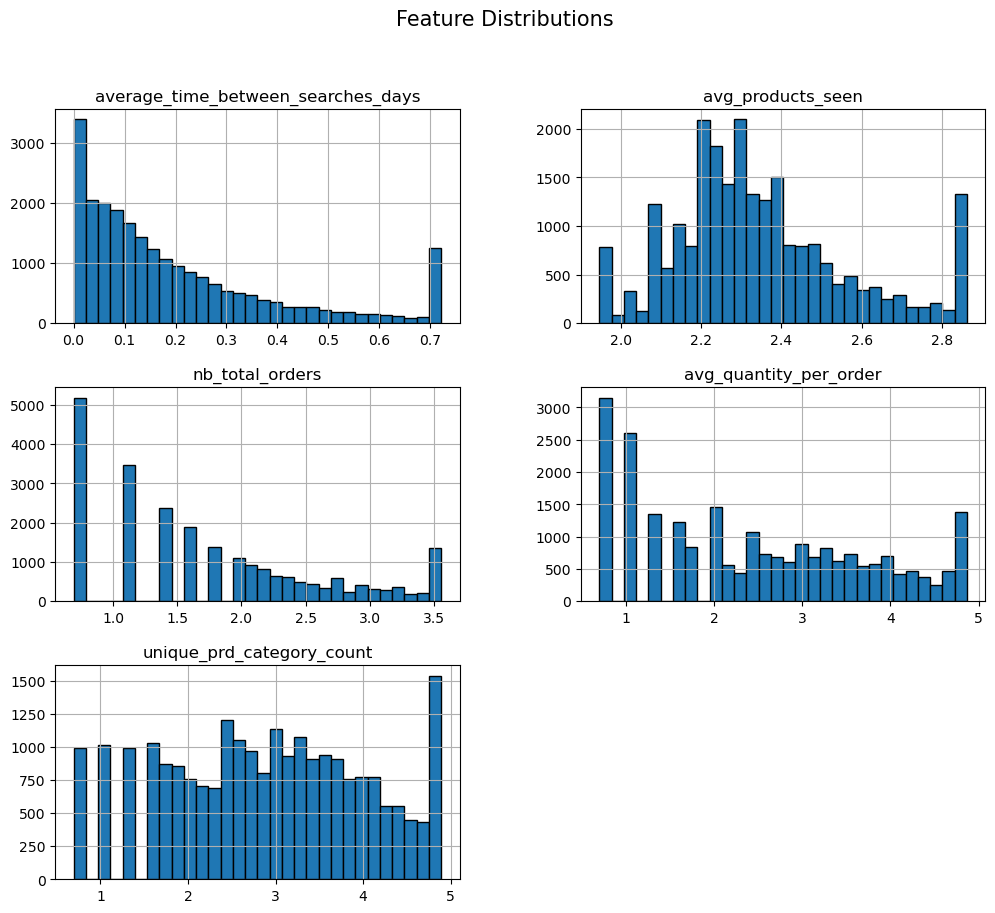

In [25]:
df_cleaned[skewed_cols].hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=15)
plt.show()

## 2.2. Categorical columns encoding

In [26]:
cat_columns = df_cleaned.select_dtypes(include=['object', 'category']).columns
analyse_data(df_cleaned[cat_columns])

,count_non_null_values,%_non_null_values,nb_unique_values,cardinal,column_type
client_id,23662,100.0,23662,1.000000,object
device_usage_category,23662,100.0,3,0.000127,object
client_type,23662,100.0,6,0.000254,object
market,23662,100.0,5,0.000211,object
preferred_channel,23662,100.0,4,0.000169,object
favorite_prd_category_2,23662,100.0,117,0.004945,object


We will apply **one-hot encoding** to the features with a low number of unique values. We will apply **ordinal encoding** for others. 

In [27]:
one_hot_encoding_columns = ['device_usage_category', 'client_type', 'market', 'preferred_channel']
other_encoding_columns = ['favorite_prd_category_2']

In [28]:
df_one_hot = pd.get_dummies(df_cleaned[one_hot_encoding_columns], drop_first=True)

ord_encoder = OrdinalEncoder()
df_ordinal = df_cleaned[other_encoding_columns].copy()
df_ordinal[other_encoding_columns] = ord_encoder.fit_transform(df_ordinal)

df_cleaned = df_cleaned.drop(columns=one_hot_encoding_columns + other_encoding_columns)

df_cleaned = pd.concat([df_cleaned, df_one_hot, df_ordinal], axis=1)

## 2.3. Normalization

In [29]:
feature_cols = df_cleaned.drop('client_id', axis=1).columns
scaler = MinMaxScaler()
df_cleaned[feature_cols] = scaler.fit_transform(df_cleaned[feature_cols])

In [30]:
df_cleaned.head()

,client_id,avg_keyword_word_count,average_time_between_searches_days,unique_prd_category_count,avg_products_seen,nb_total_orders,nb_different_channels,avg_quantity_per_order,device_usage_category_mixed,device_usage_category_mobile_or_tablet_only,...,client_type_Revendeurs,client_type_Utilisateurs,market_Habitat / Petit Tertiaire,market_Industrie,market_Installateur,market_Tertiaire,preferred_channel_FACE,preferred_channel_TCI,preferred_channel_TEL,favorite_prd_category_2
0,000195,0.083686,0.394855,0.495435,0.879224,0.882443,0.666667,0.539361,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.189655
1,0002b0,0.183036,0.000355,0.463621,0.160784,0.437692,0.000000,0.097141,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.129310
2,000973,0.100962,0.055022,0.730976,0.290323,0.484346,0.000000,0.692470,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.206897
3,0013cd,0.122768,0.273199,0.571308,0.227826,0.141662,0.000000,0.692470,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.206897
4,0017ab,0.187500,1.000000,0.000000,0.000000,0.437692,0.333333,0.539361,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.655172


In [31]:
df_clus = df_cleaned.copy()

# 3. Model creation and training

## 3.1. Different model testing

Let's test different clustering methods:
- KMeans
- DBSCAN
- Agglomerative

To compare each model, we'll calculate the **silhouette score**, the **Davies-Bouldin score** and **Calinski-Harabasz score**. 


- **Silhouette score** measures **how similar each point is to its own cluster** compared to other clusters. A **higher value** (close to 1) indicates **well-separated** and **cohesive** clusters, while a negative value suggests poor clustering.

- **Davies-Bouldin score** evaluates the **average similarity ratio** of each cluster with the cluster that is most similar to it. A **lower value** indicates **better clustering**, with clusters being well-separated and compact.

- **Calinski-Harabasz Index** measures cluster separation and compactness. A **higher score** indicates **better clustering**, meaning clusters are **well-separated** and **dense**. It is the ratio of between-cluster variance to within-cluster variance.  


### 3.1.1. KMeans

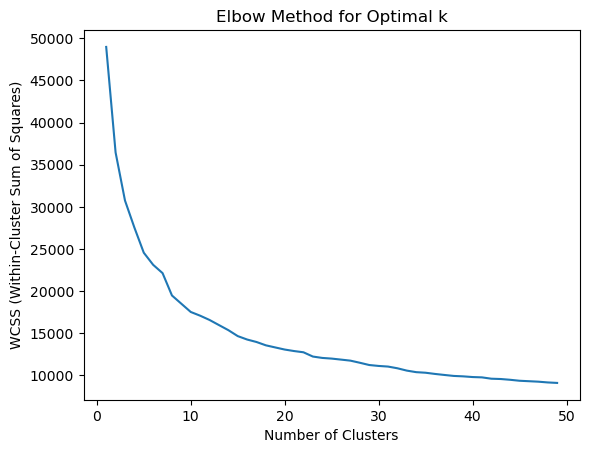

In [32]:
wcss = []
for i in range(1, 50):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_clus.drop('client_id', axis=1))
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 50), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()


According to **elbow method** the ideal number of clusters is **approximately 12**.

In [33]:
kmeans = KMeans(n_clusters=12, random_state=42)
kmeans_labels = kmeans.fit_predict(df_clus.drop('client_id', axis=1))

silhouette = silhouette_score(df_clus[feature_cols], kmeans.labels_)
davies_bouldin = davies_bouldin_score(df_clus[feature_cols], kmeans.labels_)
chi_score = calinski_harabasz_score(df_clus[feature_cols], kmeans.labels_)

print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Score: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {chi_score}")

Silhouette Score: 0.24301523336878822
Davies-Bouldin Score: 1.4721736113352513
Calinski-Harabasz Index: 4202.686928064233


### 3.1.2. DBSCAN

In [34]:
dbscan = DBSCAN(eps=1.1)
dbscan_labels = dbscan.fit_predict(df_clus.drop('client_id', axis=1))

silhouette = silhouette_score(df_clus[feature_cols], dbscan.labels_)
davies_bouldin = davies_bouldin_score(df_clus[feature_cols], dbscan.labels_)
chi_score = calinski_harabasz_score(df_clus[feature_cols], dbscan.labels_)

print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Score: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {chi_score}")

dbscan_cluster_counts = len(set(dbscan_labels))
print(f"DBSCAN Cluster Counts:\n{dbscan_cluster_counts}")

outliers_count = (dbscan.labels_ == -1).sum()
print(f"Number of outliers: {outliers_count}")
print("\n")

Silhouette Score: 0.31362323092090205
Davies-Bouldin Score: 1.6048983333597322
Calinski-Harabasz Index: 2781.9308751622125
DBSCAN Cluster Counts:
11
Number of outliers: 12




### 3.1.3 Agglomerative Clustering

In [35]:
agglomerative = AgglomerativeClustering(n_clusters=10)
agglo_labels = agglomerative.fit_predict(df_clus.drop('client_id', axis=1))

silhouette = silhouette_score(df_clus[feature_cols], agglomerative.labels_)
davies_bouldin = davies_bouldin_score(df_clus[feature_cols], agglomerative.labels_)
chi_score = calinski_harabasz_score(df_clus[feature_cols], agglomerative.labels_)

print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Score: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {chi_score}")

Silhouette Score: 0.284557365231168
Davies-Bouldin Score: 1.3637255604715806
Calinski-Harabasz Index: 4654.306828391171


**Agglomerative clustering** seems to be the **best model**. Let's visualize the different clusters using **PCA**.

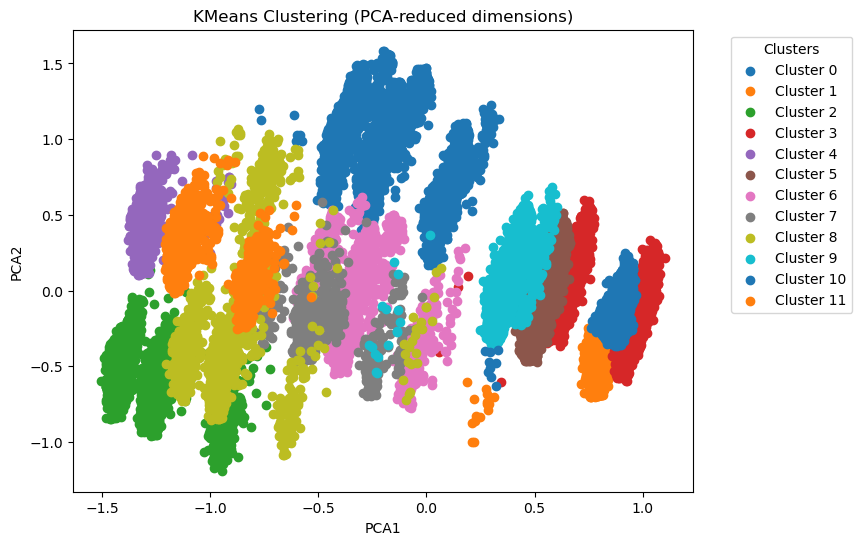

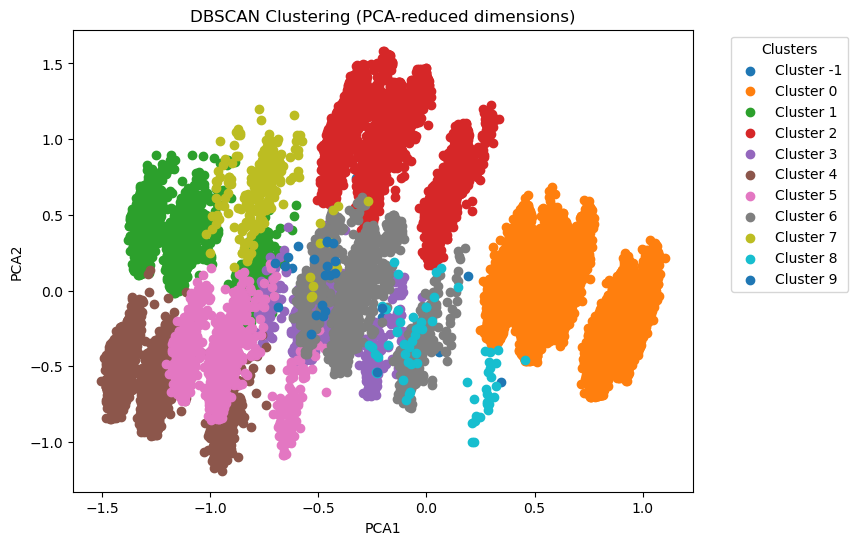

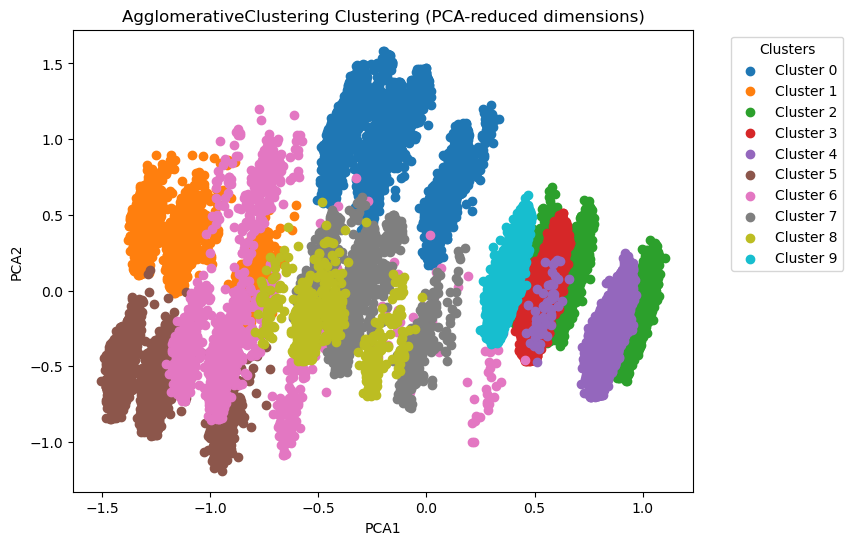

In [36]:
for model in [kmeans, dbscan, agglomerative]: 
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df_clus[feature_cols])
    
    df_pca = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
    df_pca['Cluster'] = model.labels_

    plt.figure(figsize=(8, 6))
    
    for cluster in np.unique(df_pca['Cluster']):
        cluster_data = df_pca[df_pca['Cluster'] == cluster]
        plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')
    
    plt.title(f'{model.__class__.__name__} Clustering (PCA-reduced dimensions)')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

## 3.2. Refined clustering

**Observation:** Some clusters are **better defined** by certain models, while others perform better with different approaches.  

To **enhance clustering quality**, we'll apply a **refinement strategy**:  
1. First, we'll perform **Agglomerative Clustering** with **10 clusters**.  
2. We'll identify clusters with a **DB Score over a set threshold**.  
3. For these weaker clusters, we'll apply **DBSCAN** to further **refine the structure** and create more meaningful sub-clusters.  


Processing initial cluster 0
DBSCAN unique labels found: [0]
Outcome: Not divided
Processing initial cluster 1
DBSCAN unique labels found: [0]
Outcome: Not divided
Processing initial cluster 2
DBSCAN unique labels found: [0]
Outcome: Not divided
Processing initial cluster 3
DBSCAN unique labels found: [0]
Outcome: Not divided
Processing initial cluster 4
DBSCAN unique labels found: [0]
Outcome: Not divided
Processing initial cluster 5
DBSCAN unique labels found: [0]
Outcome: Not divided
Processing initial cluster 6
DBSCAN unique labels found: [-1  0  1  2]
Outcome: Divided into 4 new clusters
Processing initial cluster 7
DBSCAN unique labels found: [0]
Outcome: Not divided
Processing initial cluster 8
DBSCAN unique labels found: [-1  0  1]
Outcome: Not divided
Processing initial cluster 9
DBSCAN unique labels found: [0]
Outcome: Not divided
Silhouette Score: 0.2909279088751184
Davies-Bouldin Score: 1.4006467119225035
Calinski-Harabasz Index: 3662.638984997508


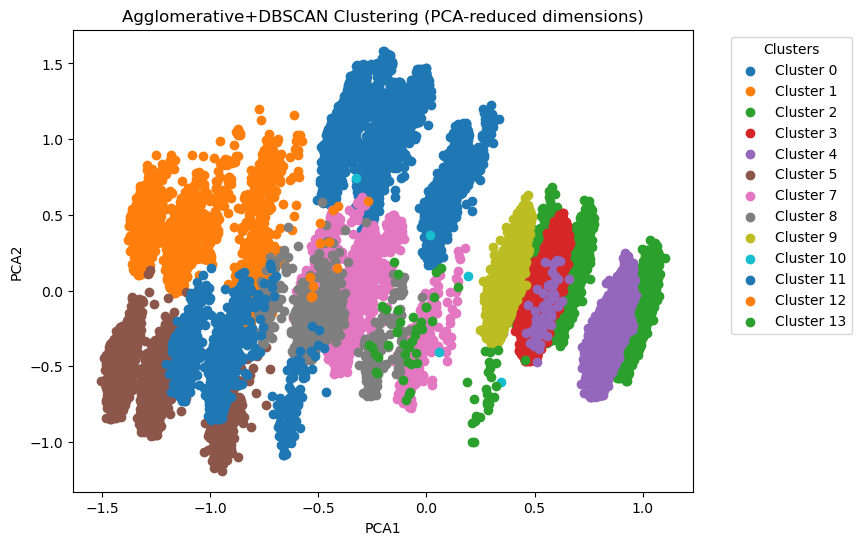

In [37]:
agglo = AgglomerativeClustering(n_clusters=10)
agglo_labels = agglo.fit_predict(df_clus.drop('client_id', axis=1))
overall_labels = agglo_labels.copy()
label_counter = overall_labels.max() + 1
threshold = 1.2
eps=1.1
for cluster in np.unique(agglo_labels):
    print(f"Processing initial cluster {cluster}")
    idx = np.where(agglo_labels == cluster)[0]
    if len(idx) < 2:
        print("Outcome: Not divided (cluster too small)")
        continue
    sub_data = df_clus.loc[idx, feature_cols]
    db = DBSCAN(eps=eps)
    sub_labels = db.fit_predict(sub_data)
    unique_sub = np.unique(sub_labels)
    print(f"DBSCAN unique labels found: {unique_sub}")

    if len(unique_sub) < 2:
        print("Outcome: Not divided")
        continue
    if -1 in unique_sub:
        mask = sub_labels != -1
        if len(np.unique(sub_labels[mask])) < 2:
            print("Outcome: Not divided (insufficient non-noise clusters)")
            continue
        score = davies_bouldin_score(sub_data[mask], sub_labels[mask])
    else:
        score = davies_bouldin_score(sub_data, sub_labels)
    if score > threshold:
        num_new_clusters = len(unique_sub)
        print(f"Outcome: Divided into {num_new_clusters} new clusters")
        for sub_cluster in unique_sub:
            sub_idx = idx[sub_labels == sub_cluster]
            if len(sub_idx) == 0:
                continue
            overall_labels[sub_idx] = label_counter
            label_counter += 1
    else:
        print("Outcome: Not divided")
silhouette = silhouette_score(df_clus[feature_cols], overall_labels)
davies_bouldin = davies_bouldin_score(df_clus[feature_cols], overall_labels)
chi_score = calinski_harabasz_score(df_clus[feature_cols], overall_labels)
print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Score: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {chi_score}")
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_clus[feature_cols])
df_pca = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = overall_labels
plt.figure(figsize=(8, 6))
for clust in np.unique(df_pca['Cluster']):
    cluster_data = df_pca[df_pca['Cluster'] == clust]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {clust}')
plt.title('Agglomerative+DBSCAN Clustering (PCA-reduced dimensions)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


The **refinement strategy** didn't yield significant improvements in performance.

## 3.3. Parameter weight ajustment

Another method we can try is **adjusting parameter weights**. We can, for instance, give a **higher weight to client categorical columns**, as they are more relevant for **categorization clustering**. Also, `nb_total_orders` seems to be an **important characteristic** for classifying clusters.  

In [108]:
df_clus_ajusted = df_clus.copy()

We multiply the `nb_total_orders` and the categorical columns by 3.

In [111]:
df_clus_ajusted['nb_total_orders'] = df_clus_ajusted['nb_total_orders'] * 3
df_clus_ajusted.loc[:, (df_clus_ajusted.nunique() == 2)] *= 3

### 3.3.1. KMeans

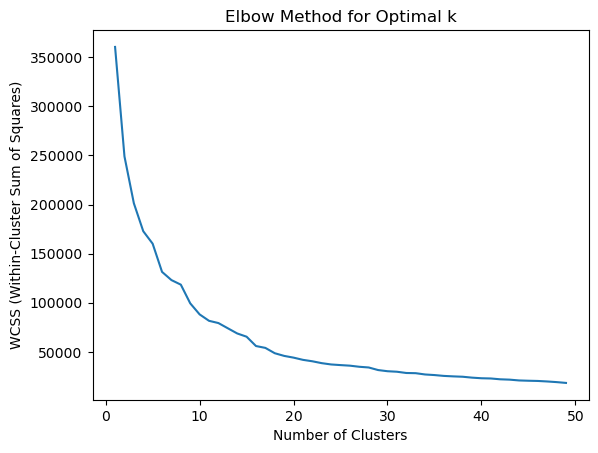

In [115]:
wcss = []
for i in range(1, 50):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_clus_ajusted.drop('client_id', axis=1))
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 50), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()


In [116]:
kmeans = KMeans(n_clusters=15, random_state=42)
kmeans_labels = kmeans.fit_predict(df_clus_ajusted.drop('client_id', axis=1))

silhouette = silhouette_score(df_clus_ajusted[feature_cols], kmeans.labels_)
davies_bouldin = davies_bouldin_score(df_clus_ajusted[feature_cols], kmeans.labels_)
chi_score = calinski_harabasz_score(df_clus_ajusted[feature_cols], kmeans.labels_)

print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Score: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {chi_score}")

Silhouette Score: 0.4391428134374903
Davies-Bouldin Score: 0.973334954175336
Calinski-Harabasz Index: 7626.320988711454


### 3.3.2. DBSCAN

In [124]:
dbscan = DBSCAN(eps=1.5)
dbscan_labels = dbscan.fit_predict(df_clus_ajusted.drop('client_id', axis=1))

silhouette = silhouette_score(df_clus_ajusted[feature_cols], dbscan.labels_)
davies_bouldin = davies_bouldin_score(df_clus_ajusted[feature_cols], dbscan.labels_)
chi_score = calinski_harabasz_score(df_clus_ajusted[feature_cols], dbscan.labels_)

print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Score: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {chi_score}")

dbscan_cluster_counts = len(set(dbscan_labels))
print(f"DBSCAN Cluster Counts:\n{dbscan_cluster_counts}")

outliers_count = (dbscan.labels_ == -1).sum()
print(f"Number of outliers: {outliers_count}")
print("\n")

Silhouette Score: 0.6006750198838983
Davies-Bouldin Score: 1.295151019398563
Calinski-Harabasz Index: 5357.171685747589
DBSCAN Cluster Counts:
59
Number of outliers: 57




### 3.3.3. Agglomarative clustering

In [125]:
agglomerative = AgglomerativeClustering(n_clusters=30)
agglo_labels = agglomerative.fit_predict(df_clus_ajusted.drop('client_id', axis=1))

silhouette = silhouette_score(df_clus_ajusted[feature_cols], agglomerative.labels_)
davies_bouldin = davies_bouldin_score(df_clus_ajusted[feature_cols], agglomerative.labels_)
chi_score = calinski_harabasz_score(df_clus_ajusted[feature_cols], agglomerative.labels_)

print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Score: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {chi_score}")

Silhouette Score: 0.4712458200830339
Davies-Bouldin Score: 0.8244364159556441
Calinski-Harabasz Index: 9107.373984325377


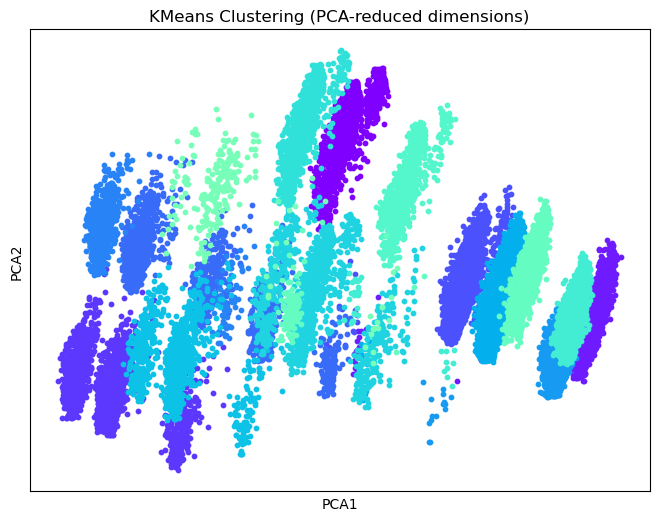

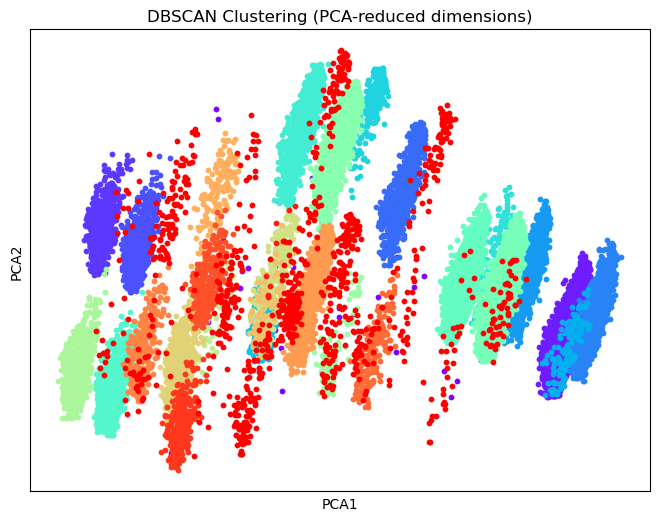

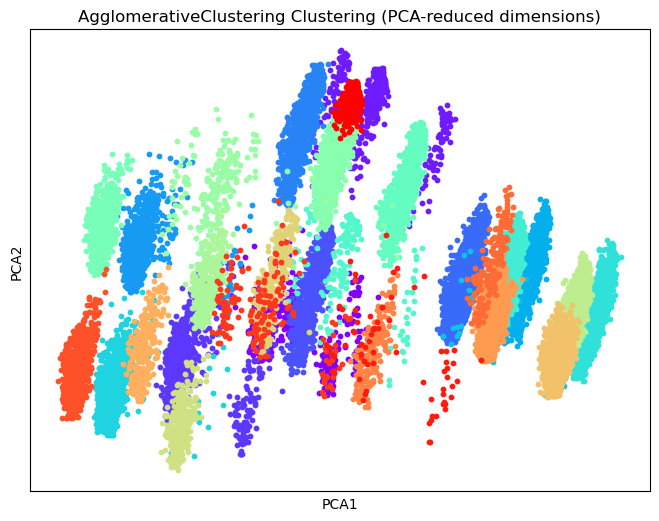

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

for model in [kmeans, dbscan, agglomerative]: 
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df_clus[feature_cols])
    
    df_pca = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
    df_pca['Cluster'] = model.labels_

    # Get unique clusters and create a more contrasted colormap
    unique_clusters = np.unique(df_pca['Cluster'])
    num_clusters = len(unique_clusters)
    
    # Use "rainbow" colormap for higher contrast
    # colors = plt.cm.get_cmap("rainbow", num_clusters)
    plt.colormaps["rainbow"]

    plt.figure(figsize=(8, 6))
    
    for i, cluster in enumerate(unique_clusters):
        cluster_data = df_pca[df_pca['Cluster'] == cluster]
        plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], 
                    color=colors(i), s=10)

    plt.title(f'{model.__class__.__name__} Clustering (PCA-reduced dimensions)')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.xticks([])
    plt.yticks([])
    plt.show()


Scores improve **significantly** using this **parameter weight adjustment** method. The **agglomerative method** seems to work the best here too.  

## 3.4. Result analysis

In [133]:
df['Cluster'] = dbscan_labels

In [134]:
df.Cluster.value_counts()

Cluster
 0     4485
 13    3411
 11    1433
 14    1426
 4     1231
 12    1217
 5     1130
 2      971
 16     860
 22     787
 10     786
 3      698
 1      695
 19     688
 7      351
 25     336
 8      332
 26     282
 18     272
 23     269
 24     193
 9      184
 21     163
 6      140
 15     111
 29     110
 32     102
 38      92
 43      92
 44      82
 20      78
-1       57
 40      54
 51      54
 31      46
 17      38
 33      36
 28      32
 46      31
 49      30
 41      28
 48      24
 30      23
 36      22
 50      21
 37      16
 47      15
 35      15
 39      14
 52      14
 42      13
 54      13
 45      12
 34      12
 27       9
 53       9
 55       6
 56       6
 57       5
Name: count, dtype: int64

In [129]:
df_cluster_means = df.drop('client_id', axis=1).groupby('Cluster')[num_cols].mean()
df_cluster_modes = df.drop('client_id', axis=1).groupby('Cluster')[cat_columns].agg(lambda x: x.mode().iloc[0])
df_cluster_summary = df_cluster_means.merge(df_cluster_modes, on='Cluster')
df_cluster_summary

,interaction_rate,avg_keyword_word_count,average_time_between_searches_days,unique_prd_category_count,purchase_activity_rate,avg_products_seen,nb_total_orders,nb_different_product_ordered,nb_different_channels,avg_quantity_per_order,device_usage_category,client_type,market,preferred_channel,favorite_prd_category_2
Cluster,,,,,,,,,,,,,,,
0,0.008182,2.338818,0.302210,38.766026,0.024995,10.211315,4.474359,6.189103,1.129808,9.474359,desktop_only,Autres,Autres,DIGIT,APPAREILLAGE MURAL
1,0.009583,2.333978,0.262820,133.922925,0.013874,9.678483,35.903162,52.891304,2.527668,50.047431,mixed,Installateurs,Tertiaire,DIGIT,CABLE INDUSTRIEL
2,0.006825,2.247286,0.283334,22.200000,0.047372,10.179836,6.089286,11.291667,1.480952,84.439286,desktop_only,Intégrateurs,Industrie,DIGIT,MARQUAGE ET REPERAGE
3,0.008209,2.290415,0.284971,56.498094,0.032074,9.977737,13.997459,24.523507,1.806861,61.569250,desktop_only,Installateurs,Industrie,DIGIT,MARQUAGE ET REPERAGE
4,0.005590,2.429625,0.297093,24.208710,0.010233,9.755747,6.356615,9.717338,1.756779,42.271159,desktop_only,Installateurs,Habitat / Petit Tertiaire,TEL,CABLE INDUSTRIEL
5,0.006049,2.407845,0.317824,55.197201,0.003785,9.980413,13.319338,20.454198,1.879135,54.647583,desktop_only,Installateurs,Tertiaire,TEL,CABLE INDUSTRIEL
6,0.010993,2.312008,0.291826,21.829727,0.030739,10.883780,2.923801,5.174976,1.242709,28.087488,desktop_only,Utilisateurs,Tertiaire,DIGIT,APPAREILLAGE MURAL
7,0.011537,2.240603,0.267763,45.313274,0.042044,9.881225,9.092035,13.960177,2.001770,22.157522,mixed,Installateurs,Habitat / Petit Tertiaire,DIGIT,APPAREILLAGE MURAL
8,0.010056,2.273679,0.283391,8.173913,0.072964,8.842416,6.280193,10.169082,1.797101,17.367150,mobile_or_tablet_only,Installateurs,Habitat / Petit Tertiaire,FACE,APPAREILLAGE MURAL
